In [5]:
%matplotlib inline
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import collections
import glob
from scipy import interpolate
from datetime import date
from satpy.scene import Scene
import warnings
warnings.filterwarnings("ignore")

# Data Visualization

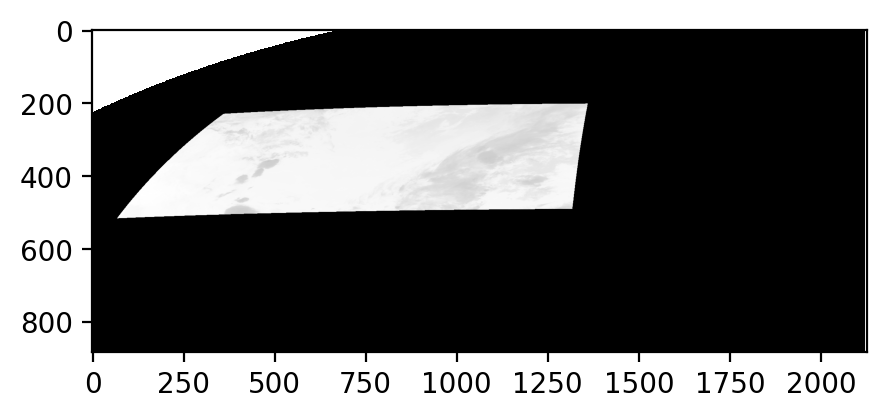

In [6]:
filenames = glob.glob('/usr/commondata/weather/IR/IR_2012_raw/goes13.2012.153.013150.BAND_04.nc')
scn = Scene(filenames=filenames, reader='goes-imager_nc')

available = scn.available_dataset_names()
scn.load(available)
data = scn[available[0]].values
lats = scn[available[1]].values
lons = scn[available[2]].values

mask_lat_C = (30<= lats) * (lats <=45)
mask_long_C = (-115<= lons) * (lons <=-80)
mask = mask_lat_C * mask_long_C

r = data * mask
fig = plt.figure(figsize=(5,5),dpi=200)
im = plt.imshow(r, cmap='Greys_r')
plt.show()

# Get data and Interpolation

In [2]:
# 整合
def get_proj_data(filename: str, long_range: tuple, lat_range: tuple):
    # read nc data
    scn = Scene(filenames=[filename], reader='goes-imager_nc')

    available = scn.available_dataset_names()
    scn.load(available)
    radiance = scn[available[0]].values
    lat = scn[available[1]].values
    long = scn[available[2]].values
    
    # select Reg
    mask_lat_C = (np.min(lat_range) <= lat) *  (lat <= np.max(lat_range))
    mask_long_C = (np.min(long_range) <= long) *  (long <= np.max(long_range))
    mask = mask_lat_C * mask_long_C
    y, x = np.nonzero(mask) # indices of selected region
    
    # proj to regular grid
    toGridIndex = lambda x, rang: ((x - x.min()) / (x.max() - x.min()) * rang).astype(int)
    width = int((np.max(lat_range) - np.min(lat_range)) / 0.04)
    length = int((np.max(long_range) - np.min(long_range)) / 0.04)
    lons_grid_index = toGridIndex(long[mask], length)
    lats_grid_index = toGridIndex(lat[mask], width)
    grid = np.zeros((lats_grid_index.max(), lons_grid_index.max())) # regular grid
    N = np.zeros_like(grid) # counter
    
    for i in range(x.shape[0]):
        grid[lats_grid_index[i]-1, lons_grid_index[i]-1] += radiance[y[i],x[i]]
        N[lats_grid_index[i]-1, lons_grid_index[i]-1] += 1
    projected = np.flip(grid / (N+1e-10), 0)
    
    # interpolation with linear method
    a, b = np.nonzero(projected)
    values = projected[a, b]
    grid_x, grid_y = np.mgrid[0:374:375j, 0:374:375j]
    grid_z = interpolate.griddata((a, b), values, (grid_x, grid_y), method='linear')
    return projected

# 整体流程

## 生成数据csv表

In [14]:
# generate tabels
save_path = '/usr/commondata/weather/dataset_release/IR_dataset_QingHua/'
IR_path = '/usr/commondata/weather/IR/IR_2012_project_calibration/'
StageIV_path = '/usr/commondata/weather/StageIV/StageIV_2012_project_calibration/'
split_dict = {'train': ['-105,-90', '30,45', '153', '213'],
              'val': ['-105,-90', '30,45', '214', '244'],
              'test_W': ['-115,-110', '35,40', '153', '244'], 
              'test_E': ['-85,-80', '35,40', '153', '244']}

def generate_csv(ori_path, split_dict):
    for k, v in split_dict.items():
        X_names = os.listdir(IR_path)
        y_names = os.listdir(StageIV_path)
        start_day, end_day = int(v[2]), int(v[3])
        
        X = []
        for x in X_names:
            name_info = x.split('.')
            day = int(name_info[0])
            if (day >= start_day) & (day <= end_day):
                X.append(IR_path+x)
        Y = []
        for y in y_names:
            name_info = y.split('.')
            day = int(name_info[0])
            if (day >= start_day) & (day <= end_day):
                Y.append(StageIV_path+y)
            
        df = pd.DataFrame(columns=['long', 'lat', 'start_day', 'end_day', 'X', 'Y'])
        df['X'] = pd.Series(X)
        df['Y'] = pd.Series(Y)
        df['long'][0] = v[0]
        df['lat'][0] = v[1]
        df['start_day'][0] = start_day
        df['end_day'][0] = end_day

        df.to_csv(save_path+k+'.csv', index=False)

generate_csv(path, split_dict)

## 主要函数

In [15]:
# decode
def crop_match(csv_path, long_ori, lat_ori):
    data_df = pd.read_csv(csv_path)
    long = data_df['long'][0].split(',')
    long_crop = (int(long[0]), int(long[1]))
    lat = data_df['lat'][0].split(',')
    lat_crop = (int(lat[0]), int(lat[1]))
    X_paths = data_df['X']
    y_paths = data_df['Y']

    long_idx, lat_idx = get_index(long_ori, lat_ori, long_crop, lat_crop)
    
    X_hourly = cropping(X_paths, long_idx, lat_idx, True)
    y_hourly = cropping(y_paths, long_idx, lat_idx, False)
    
    return X_hourly, y_hourly

def cropping(file_paths, long_idx, lat_idx, X):
    data = {}
    for file in file_paths:
        if pd.notna(file):
            content = np.load(file)['arr_0']
            if X:
                cropped = content[:, lat_idx[0]:lat_idx[1], long_idx[0]:long_idx[1]]
            else:
                cropped = content[lat_idx[0]:lat_idx[1], long_idx[0]:long_idx[1]]

            file_info = file.split('.')
            day = file_info[0][-3:]
            hour = file_info[1][:2]
            key = day+'.'+hour

            if key in data.keys():
                data[key] = np.concatenate((data[key], cropped))
            else:
                data[key] = cropped
    if X:
        for key in data.keys():
            data[key] = data[key].reshape(-1, 3, lat_idx[1]-lat_idx[0], long_idx[1]-long_idx[0])
            data[key] = np.mean(data[key], axis=0)
        return data
    else:
        return data
    
def get_index(long_ori, lat_ori, long_crop, lat_crop):
    long_idx = (int((np.min(long_crop) - (np.min(long_ori))) / 0.04), int((np.max(long_crop) - np.min(long_ori)) / 0.04))
    lat_idx = (int((np.min(lat_crop) - (np.min(lat_ori))) / 0.04), int((np.max(lat_crop) - np.min(lat_ori)) / 0.04))
    return long_idx, lat_idx

def date2num(start_date, end_dates):
    result=[]
    for T in end_dates:
        end_date = date(int(T[:4]), int(T[4:6]), int(T[6:8]))
        delta = (end_date - start_date)
        day=delta.days
        hour=T[8:]
        result.append('{}.{}'.format(day,hour))
    return result

## Main

In [18]:
# param

long_ori = (-115, -80)
lat_ori = (30, 45)
dataset_type = 'test_W' # train, val, test_E, test_W
csv_path = '/usr/commondata/weather/dataset_release/IR_dataset_QingHua/' + dataset_type +'.csv'

#-----------------------------------------------------------------------------------------------------------------------

print('Data processing and loading...')
X_hourly, y_hourly = crop_match(csv_path, long_ori, lat_ori)
    
# dim match
X_hourly = collections.OrderedDict(sorted(X_hourly.items()))
y_hourly = collections.OrderedDict(sorted(y_hourly.items()))

# filter
for k in list(y_hourly.keys()):
    if k not in X_hourly.keys():
        y_hourly.pop(k)

X_hourly = np.array(list(X_hourly.values()))
y_hourly = np.array(list(y_hourly.values()))
print('Done!')

Data processing and loading...
Done!


In [19]:
# save 
print('Saving...')
np.savez_compressed('{}X_{}_hourly'.format(save_path, dataset_type), X_hourly)
np.savez_compressed('{}Y_{}_hourly'.format(save_path, dataset_type), y_hourly)

Saving...


## 可视化检查

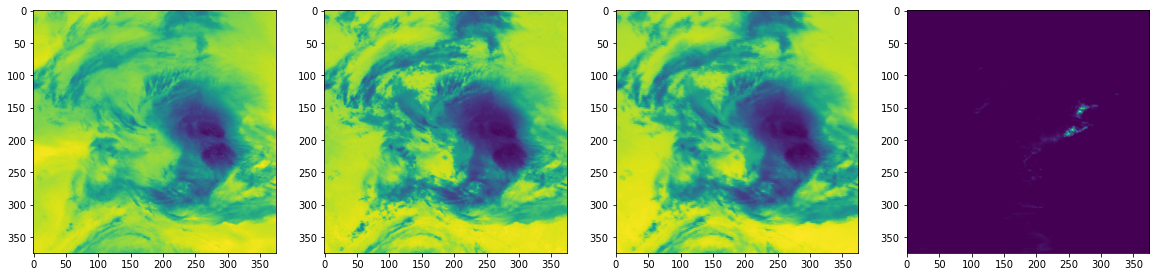

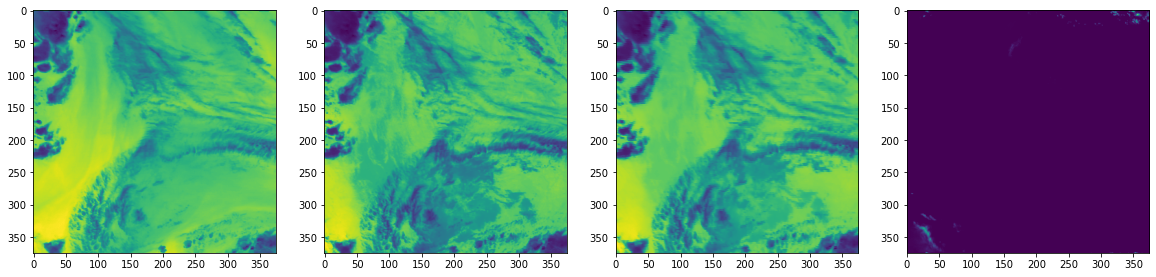

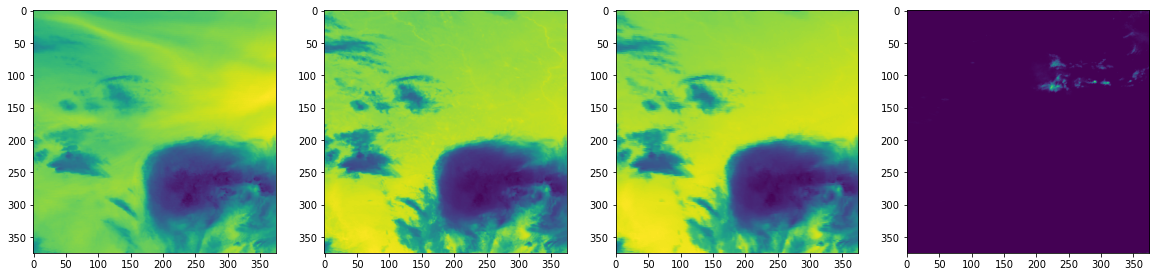

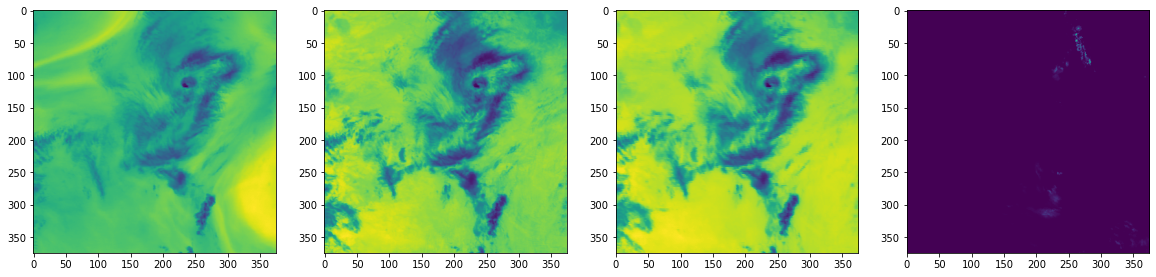

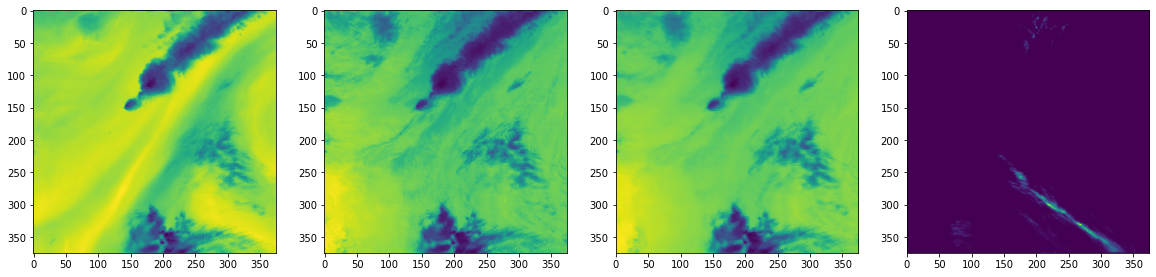

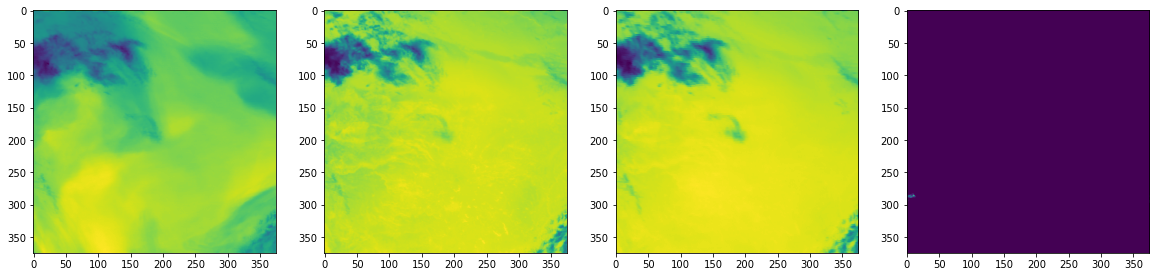

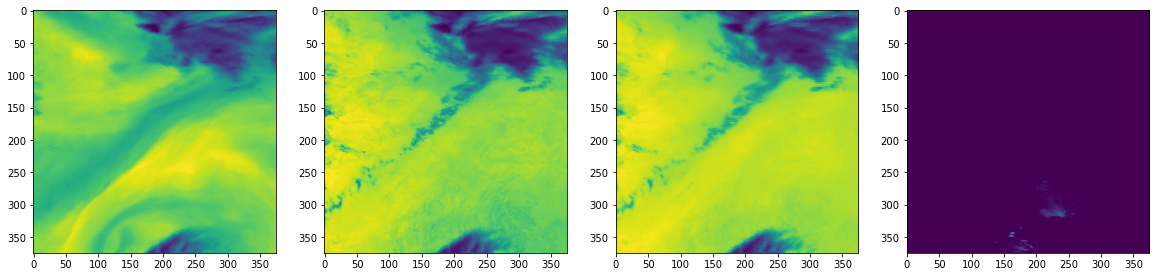

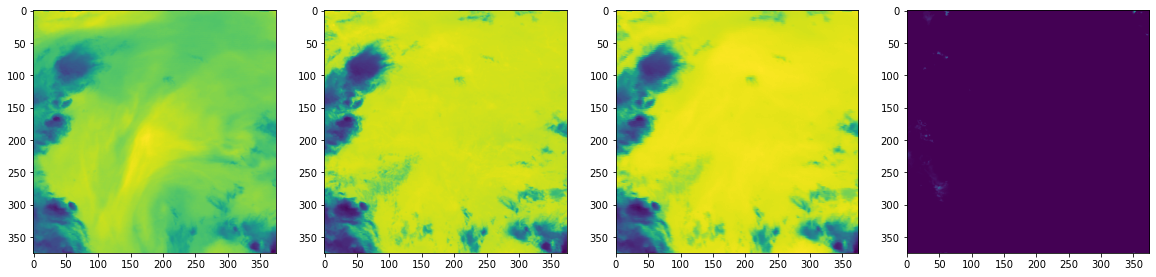

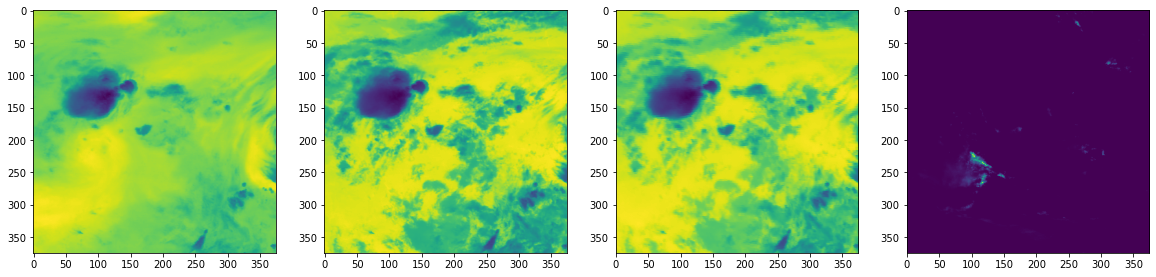

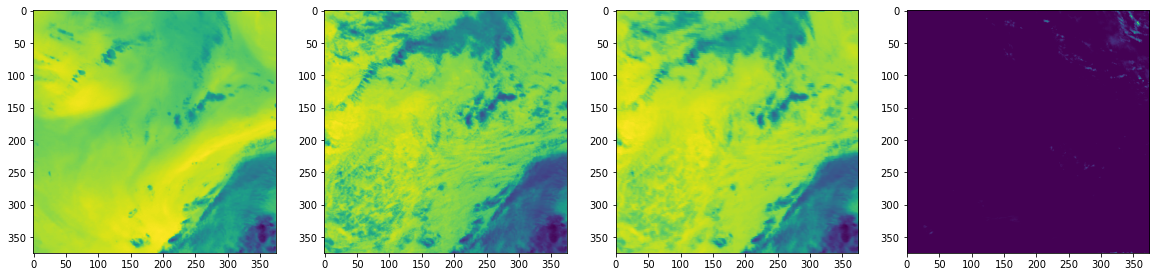

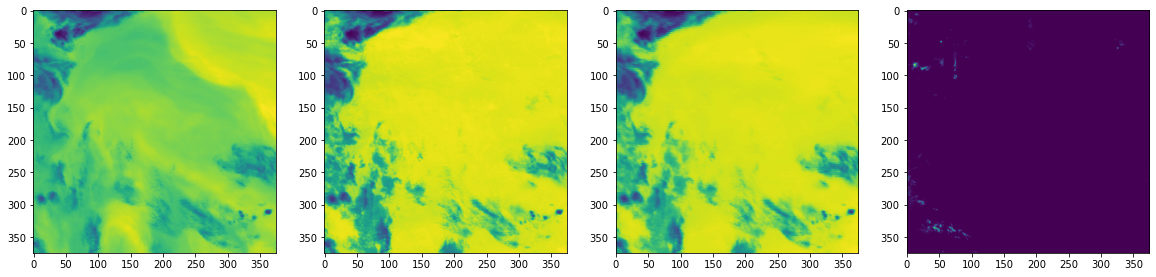

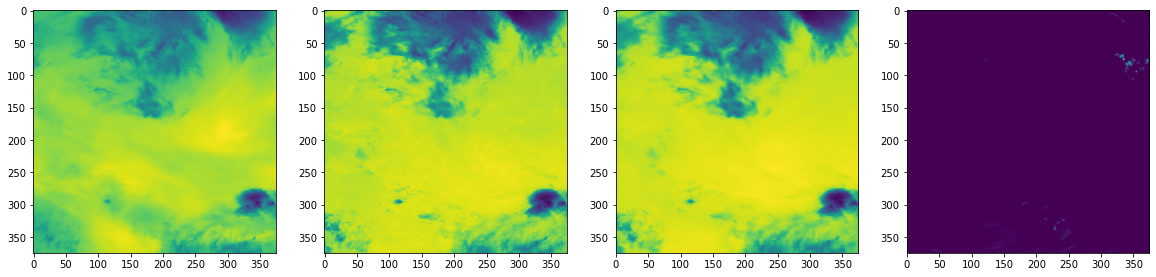

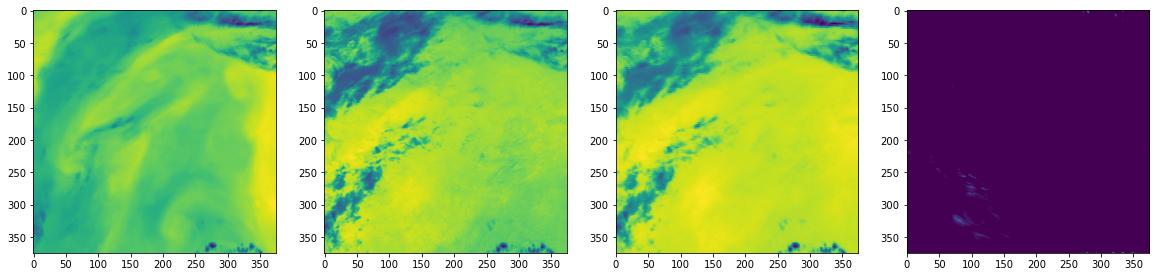

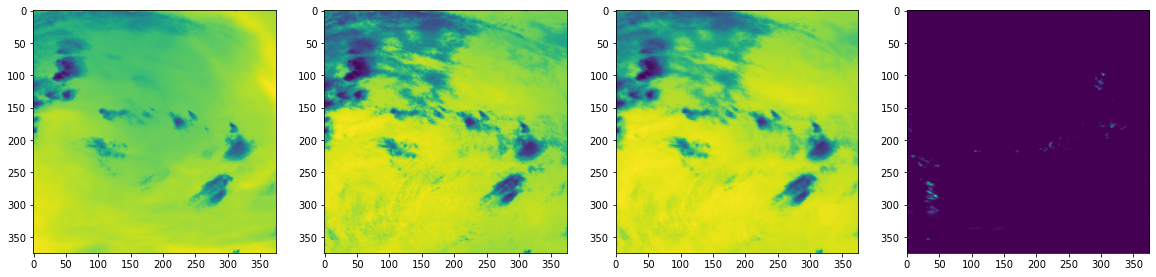

In [12]:
for k in range(len(X_train_hourly)):
    i += 1
    if i % 100 == 0:
        plt.figure(figsize=(20, 5))
        for i in range(3):
            plt.subplot(1, 4, i+1)
            plt.imshow(X_train_hourly[k][i, :])
            plt.subplot(1, 4, 4)
            plt.imshow(y_train_hourly[k])
        plt.show()
        plt.close()